# Homeworks - Big Data and Public Policy Class

*Name*: Andreas Eckmann

*E-Mail*: eckmanna@ethz.ch

In [2]:
from IPython.display import display
import pandas as pd
pd.options.display.max_columns = None # Display all columns of a dataframe
pd.options.display.max_rows = 700
from pprint import pprint

import tweepy
from tweepy import OAuthHandler
import time
import datetime
import os
import numpy as np
import pandas as pd
import yfinance as yf
import re
from bs4 import BeautifulSoup

In [3]:
# To plot pretty figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
#%matplotlib notebook
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings = lambda *a, **kw: None

**Step 1a: `X` variables** [week 2]
- Fetch the data using the **twitter API** or any other API or website that you are interested in.
- Beware of the rate limits and organize your program so as to overcome them if needed
- The data should include some text, but might also have other interesting variables (retweets, favorites...)
- Create some (non-text based) `X_num` variables that you will use for the prediction

In [2]:
#this you get when you make create an application on twitter as a dev
consumer_key="7X8q1LteL1qOLRg4DSoiI0lyk"
consumer_secret="Bb08vV5XoxDEP4SGLJfkvEpuwvxEDvzVSRGTptzQCjC9XVmquP"
access_token="1230145588659998721-EQb8DoMYnorBtqAuEPMZtZcXumzuAe"
access_token_secret="mzurpOu1LWhj0NU9pctgYZ6OBzhQvyqw8hvRNpe3yI4Qc"

## Accessing the Twitter API using `tweepy`

Twitter requires all requests to use `OAuth` for authentication

In [3]:
# Authenticate to Twitter
auth = OAuthHandler(consumer_key, consumer_secret) #creating an OAuthHandler instance
auth.set_access_token(access_token, access_token_secret)

# We specify wait_on_rate_limit_notify==True & wait_on_rate_limit=True. The API method will wait once you’ve reached your rate limit and prints out a message
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [4]:
# test authentication
try:
    api.verify_credentials()
    print("Authentication OK")
except:
    print("Error during authentication")


Authentication OK


In [5]:
# most recent tweets about Beyond Meat
tweets = api.search(q="Beyond Meat", lang="en") # TODO: How is it set to recent tweets?
for tweet in tweets:
    print(tweet.text) # printing the first tweet

RT @business: Impossible Foods has been in talks with investors about raising more funds after receiving excess demand for a $500 million f…
RT @business: Impossible Foods has been in talks with investors about raising more funds after receiving excess demand for a $500 million f…
RT @business: Impossible Foods has been in talks with investors about raising more funds after receiving excess demand for a $500 million f…
Impossible Foods has been in talks with investors about raising more funds after receiving excess demand for a $500… https://t.co/FqZHGHOJTS
RT @business: Impossible Foods has been in talks with investors about raising more funds after receiving excess demand for a $500 million f…
RT @business: Impossible Foods has been in talks with investors about raising more funds after receiving excess demand for a $500 million f…
Impossible Foods has been in talks with investors about raising more funds after receiving excess demand for a $500… https://t.co/g7HTynboG1
RT @business:

In [6]:
target='BeyondMeat' #'BeyondMeat'
user = api.get_user(target) # argument = id, user_id, screen_name
pprint(user._json)

{'contributors_enabled': False,
 'created_at': 'Thu May 03 05:40:43 +0000 2012',
 'default_profile': False,
 'default_profile_image': False,
 'description': "Meat that's made from plants, made for meat lovers. \n"
                '#GoBeyond',
 'entities': {'description': {'urls': []},
              'url': {'urls': [{'display_url': 'beyondmeat.com',
                                'expanded_url': 'http://www.beyondmeat.com',
                                'indices': [0, 22],
                                'url': 'http://t.co/4ZbzGc2iMf'}]}},
 'favourites_count': 18174,
 'follow_request_sent': False,
 'followers_count': 109102,
 'following': True,
 'friends_count': 692,
 'geo_enabled': True,
 'has_extended_profile': False,
 'id': 569714177,
 'id_str': '569714177',
 'is_translation_enabled': False,
 'is_translator': False,
 'lang': None,
 'listed_count': 1132,
 'location': 'El Segundo, CA',
 'name': 'Beyond Meat',
 'notifications': False,
 'profile_background_color': 'FAF5E2',
 'profile

In [7]:
# Some attributes of the `user` object:
print("Name:", user.name)
print("Screen name:", user.screen_name)
print("Number of followers:" ,  user.followers_count)
pprint("description: " + user.description)
pprint("Number of tweets published: " + str(user.statuses_count))
pprint("friends_count: " + str(user.friends_count))

Name: Beyond Meat
Screen name: BeyondMeat
Number of followers: 109102
"description: Meat that's made from plants, made for meat lovers. \n#GoBeyond"
'Number of tweets published: 24030'
'friends_count: 692'


In [15]:
# Note: This code (cell) was written with the help of Gian-Luca and Felix 
def fetch_tweets(account, n_tweets):
    """Fetch data from Beyond Meat twitter account"""
    df_out = pd.DataFrame()
    
    try:   
        # Put the tweets into a data frame object
        tweet_count = 0
        for tweet in tweepy.Cursor(api.user_timeline, 
                                   screen_name=target, 
                                   tweet_mode ='extended',
                                   include_rts = False).items(n_tweets):
    
                    # Transform the json into a dataframe
                    df_tweet = pd.DataFrame.from_dict(tweet._json, orient='index', 
                                                      columns=[tweet_count]) # , sleep_on_rate_limit=True
      
                    # Concatenate the tweet dataframe to the df_tweets dataframe
                    df_out = pd.concat([df_tweet, df_out], axis=1)
    
                    # count the number of tweets fetched
                    tweet_count += 1 
    
        time.sleep(1)
    
    # except if TweepError arises
    except tweepy.TweepError: #the error arises when the user has protected tweets
        print("Failed to run the command "
              "on user {}, Skipping...".format(account))
    
    # except if RateLimitError arises
    except tweepy.RateLimitError:
        print("resource usage limit: {} skipped".format(account))
        time.sleep(15 * 60) # wait 15 mins
        
    return df_out

In [76]:
# IMPORTANT NOTE: This part of the code is commented out, so that the data obtained from
# twitter remains the same and does not change with the date (2020-05-02)
# Calling the function (uncomment to run)

#df_tweets = fetch_tweets(target,2000)
#print(df_tweets.columns)

C:\Users\Andi Eckmann\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Int64Index([1999, 1998, 1997, 1996, 1995, 1994, 1993, 1992, 1991, 1990,
            ...
               9,    8,    7,    6,    5,    4,    3,    2,    1,    0],
           dtype='int64', length=2000)


In [77]:
"""
# Transpose the data set
df_tweets=df_tweets.transpose() # Transpose the dataset
print(df_tweets.columns)
print(df_tweets.shape)
df_tweets.head()
"""

Index(['contributors', 'coordinates', 'created_at', 'display_text_range',
       'entities', 'extended_entities', 'favorite_count', 'favorited',
       'full_text', 'geo', 'id', 'id_str', 'in_reply_to_screen_name',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status',
       'lang', 'place', 'possibly_sensitive', 'quoted_status',
       'quoted_status_id', 'quoted_status_id_str', 'quoted_status_permalink',
       'retweet_count', 'retweeted', 'source', 'truncated', 'user'],
      dtype='object')
(2000, 30)


,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,is_quote_status,lang,place,possibly_sensitive,quoted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,retweet_count,retweeted,source,truncated,user
1999,None,None,Fri Aug 17 00:40:22 +0000 2018,"[44, 67]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,1,False,@AaronMinogueUSA @Vegicano @FollowYourHeart A+...,None,1030252963837698048,1030252963837698048,AaronMinogueUSA,1029903838604484608,1029903838604484608,925032490644905984,925032490644905984,False,en,None,NaN,NaN,NaN,NaN,NaN,0,False,"<a href=""https://sproutsocial.com"" rel=""nofoll...",False,"{'id': 569714177, 'id_str': '569714177', 'name..."
1998,None,None,Fri Aug 17 00:45:06 +0000 2018,"[15, 92]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,1,False,@BellaMarieCt1 Check out our store-locator to ...,None,1030254155766661120,1030254155766661120,BellaMarieCt1,1029875011190960133,1029875011190960133,4158821909,4158821909,False,en,None,False,NaN,NaN,NaN,NaN,0,False,"<a href=""https://sproutsocial.com"" rel=""nofoll...",False,"{'id': 569714177, 'id_str': '569714177', 'name..."
1997,None,None,Fri Aug 17 00:45:57 +0000 2018,"[16, 88]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,1,False,@BoomChickaWow1 Thank you for you patience and...,None,1030254368484933633,1030254368484933633,BoomChickaWow1,1029870996386443264,1029870996386443264,821169366440013828,821169366440013828,False,en,None,NaN,NaN,NaN,NaN,NaN,0,False,"<a href=""https://sproutsocial.com"" rel=""nofoll...",False,"{'id': 569714177, 'id_str': '569714177', 'name..."
1996,None,None,Fri Aug 17 00:46:36 +0000 2018,"[26, 127]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,1,False,@Captain_Quench @AWCanada We are working on ex...,None,1030254530938724352,1030254530938724352,Captain_Quench,1029846474383929344,1029846474383929344,2681468120,2681468120,False,en,None,NaN,NaN,NaN,NaN,NaN,0,False,"<a href=""https://sproutsocial.com"" rel=""nofoll...",False,"{'id': 569714177, 'id_str': '569714177', 'name..."
1995,None,None,Fri Aug 17 00:48:11 +0000 2018,"[28, 265]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,2,False,@paulasulllivan @WholeFoods Hey Paula! We are ...,None,1030254930806939648,1030254930806939648,paulaesullivan,1029833596381614086,1029833596381614086,1666681249,1666681249,False,en,None,NaN,NaN,NaN,NaN,NaN,1,False,"<a href=""https://sproutsocial.com"" rel=""nofoll...",False,"{'id': 569714177, 'id_str': '569714177', 'name..."


In [78]:
# Reduce data set and save the data in a csv file (uncomment to run)

#df_tweets_small=df_tweets[['full_text', 'created_at', 'retweet_count', 'favorite_count']] # 'user'
#df_tweets_small.head()

,full_text,created_at,retweet_count,favorite_count
1999,@AaronMinogueUSA @Vegicano @FollowYourHeart A+...,Fri Aug 17 00:40:22 +0000 2018,0,1
1998,@BellaMarieCt1 Check out our store-locator to ...,Fri Aug 17 00:45:06 +0000 2018,0,1
1997,@BoomChickaWow1 Thank you for you patience and...,Fri Aug 17 00:45:57 +0000 2018,0,1
1996,@Captain_Quench @AWCanada We are working on ex...,Fri Aug 17 00:46:36 +0000 2018,0,1
1995,@paulasulllivan @WholeFoods Hey Paula! We are ...,Fri Aug 17 00:48:11 +0000 2018,1,2


In [4]:
parent_path=os.path.dirname(os.getcwd()) # os.getcwd() fetchs the current path, 
data_path=os.path.join(parent_path, 'data')
print(data_path)

C:\Users\Andi Eckmann\Desktop\ETH Studium\MASTERSTUDIUM\2. Semester\Big Data for Public Policy\big_data_policy_2020\data


In [80]:
# Saving fetched tweets as CSV file (uncomment to run)
#df_tweets_small.to_csv(data_path+'/Beyond_Meat_tweets_{}.csv'.format(np.datetime64('today','D')), sep= ';')
#print("{} tweets fetched.\n".format(df_tweets.shape[0]))

2000 tweets fetched.



In [5]:
# Load the data from csv file (date 2020-05-02)
df_raw = pd.read_csv(data_path+'/Beyond_Meat_tweets_{}.csv'.format(np.datetime64('2020-05-02')), sep=';')
print(df_raw.shape,
      df_raw.head())

(2000, 5)    Unnamed: 0                                          full_text  \
0        1999  @AaronMinogueUSA @Vegicano @FollowYourHeart A+...   
1        1998  @BellaMarieCt1 Check out our store-locator to ...   
2        1997  @BoomChickaWow1 Thank you for you patience and...   
3        1996  @Captain_Quench @AWCanada We are working on ex...   
4        1995  @paulasulllivan @WholeFoods Hey Paula! We are ...   

                       created_at  retweet_count  favorite_count  
0  Fri Aug 17 00:40:22 +0000 2018              0               1  
1  Fri Aug 17 00:45:06 +0000 2018              0               1  
2  Fri Aug 17 00:45:57 +0000 2018              0               1  
3  Fri Aug 17 00:46:36 +0000 2018              0               1  
4  Fri Aug 17 00:48:11 +0000 2018              1               2  


In [6]:
# Note: This code (cell) was written with the help of Gian-Luca 
# obtain tweets as list
all_texts = list(df_raw['full_text'])

# search for hashtags and remove special characters
# and separate each word in the tweets --> important for keyword search afterwards
ats = []
hashtags = []
texts = []
for i in all_texts:
    a = []
    tex = []
    hashs = []
    for word in i.split():
        hashtag = re.search(r'(?<=#)\w+', word)
        at = re.search(r'(?<=@)\w+', word)
        if hashtag != None:
            hashs.append(hashtag.group().lower())
        if at != None:
            a.append(at.group().lower())
        else:
            text = re.search(r'\w+', word)
            if text != None:
                tex.append(text.group().lower())
    ats.append(a)
    texts.append(tex)
    hashtags.append(hashs)

In [7]:
#create data frame for overview:
dict1 = {'all_texts':all_texts, 'ats':ats, 'texts':texts, 'hashtags':hashtags}
df_ov =pd.DataFrame(dict1)
df_ov.head()

,all_texts,ats,texts,hashtags
0,@AaronMinogueUSA @Vegicano @FollowYourHeart A+...,"[aaronminogueusa, vegicano, followyourheart]","[a, with, the, gif, choice]",[]
1,@BellaMarieCt1 Check out our store-locator to ...,[bellamariect1],"[check, out, our, store, to, find, a, store, n...",[]
2,@BoomChickaWow1 Thank you for you patience and...,[boomchickawow1],"[thank, you, for, you, patience, and, support,...",[]
3,@Captain_Quench @AWCanada We are working on ex...,"[captain_quench, awcanada]","[we, are, working, on, expanding, internationa...",[]
4,@paulasulllivan @WholeFoods Hey Paula! We are ...,"[paulasulllivan, wholefoods]","[hey, paula, we, are, currently, experiencing,...",[]


In [132]:
# Save as CSV file (uncomment to run code)
# df_ov.to_csv(data_path+'/Beyond_Meat_tweets_overview_{}.csv'.format(np.datetime64('today','D')), sep= ';')

In [8]:
# define list of search strings:
hashtag_search_strings = ['stock','BYND','Nasdaq', 'vegan', 'beyondburger','GoBeyond',
                          'plantbasedparty']
text_search_strings = ['stock exchange', 'stock']

In [11]:
#loop over hashtags and texts
hash_occ = []
for i in hashtags:
    hashs = []
    for j in i:
        if j in hashtag_search_strings:
            hashs.append(j)
    hash_occ.append(hashs)
        
text_occ = []
for i in texts:
    tex = []
    for j in i:
        if j in text_search_strings:
            tex.append(j)
    text_occ.append(tex)

In [12]:
#count keyword and key hastags per tweet 
key_count = []
for i in text_occ:
    if i != None:
        key_count.append(len(i))
    else:
        key_count.append(0)
        
key_hash_count = []
for i in hash_occ:
    if i != None:
        key_hash_count.append(len(i))
    else:
        key_hash_count.append(0)


In [13]:
#get columns on time, retweets, and favourite counts from df_raw file as lists
created_at = df_raw['created_at']
retweet_count = df_raw['retweet_count']
favorite_count = df_raw['favorite_count']

# deal with date format issue and change format to yfinance default setting:
change_date = []
for i in created_at:
    convert_date = datetime.datetime.strptime(i, '%a %b %d %H:%M:%S +0000 %Y')
    change_date.append(convert_date.strftime('%Y-%m-%d'))


#create dict with all the relevant informations:
dict2 = {'tweet':all_texts, 'created at':change_date, 'favorite count':favorite_count, 'retweet count':retweet_count,
         'key hashtag count':key_hash_count,'key hashtag':hash_occ, 'keyword count':key_count ,'keywords':text_occ }

# Create data frame of all the numeric values needed for the stock predictions:
X_num_raw = pd.DataFrame(dict2)
X_num_raw.head()

,tweet,created at,favorite count,retweet count,key hashtag count,key hashtag,keyword count,keywords
0,@AaronMinogueUSA @Vegicano @FollowYourHeart A+...,2018-08-17,1,0,0,[],0,[]
1,@BellaMarieCt1 Check out our store-locator to ...,2018-08-17,1,0,0,[],0,[]
2,@BoomChickaWow1 Thank you for you patience and...,2018-08-17,1,0,0,[],0,[]
3,@Captain_Quench @AWCanada We are working on ex...,2018-08-17,1,0,0,[],0,[]
4,@paulasulllivan @WholeFoods Hey Paula! We are ...,2018-08-17,2,1,0,[],0,[]


In [14]:
# remove all the brackets in the data frame X_num
X_num_raw['keywords'] = X_num_raw['keywords'].str[0]
X_num_raw['key hashtag'] = X_num_raw['key hashtag'].str[0]
X_num_raw

,tweet,created at,favorite count,retweet count,key hashtag count,key hashtag,keyword count,keywords
0,@AaronMinogueUSA @Vegicano @FollowYourHeart A+...,2018-08-17,1,0,0,NaN,0,NaN
1,@BellaMarieCt1 Check out our store-locator to ...,2018-08-17,1,0,0,NaN,0,NaN
2,@BoomChickaWow1 Thank you for you patience and...,2018-08-17,1,0,0,NaN,0,NaN
3,@Captain_Quench @AWCanada We are working on ex...,2018-08-17,1,0,0,NaN,0,NaN
4,@paulasulllivan @WholeFoods Hey Paula! We are ...,2018-08-17,2,1,0,NaN,0,NaN
...,...,...,...,...,...,...,...,...
1995,@jeramiedreyfuss @catnamedcatteri @WSJ Thank y...,2020-05-01,1,0,0,NaN,0,NaN
1996,@ShaniasmithCo @xmxcc 😋,2020-05-01,1,0,0,NaN,0,NaN
1997,@thefawz Looks delicious 😋,2020-05-01,3,0,0,NaN,0,NaN
1998,@jamietworkowski @ImpossibleFoods 🌱💚🌎,2020-05-01,3,0,0,NaN,0,NaN


**Now:** Lets have a look at what the most popular keywords and hashtags are:

In [15]:
# most popular keyword
keyword_counts = X_num_raw['keywords'].value_counts().rename_axis('unique_values').reset_index(name='counts')
keyword_counts

,unique_values,counts
0,stock,14


In [16]:
# most popular key hashtags
key_hashtag_counts = X_num_raw['key hashtag'].value_counts().rename_axis('unique_values').reset_index(name='counts')
key_hashtag_counts

,unique_values,counts
0,beyondburger,153
1,plantbasedparty,3


In [17]:
# Now look for the numerical variables of the tweets that were tweeted
# within a day and sum them up to one value per day:
    
addition = []
set_created = set(change_date)
for k in set_created: 
    index_doppelt = [] 
    for ind,i in enumerate(change_date):
        if i == k: # put toghether all tweets per day
            index_doppelt.append(ind)
    # sum up all counts and keywords, and so on into one date        
    addition.append([k,sum(X_num_raw.iloc[index_doppelt]['retweet count']),
                     sum(X_num_raw.iloc[index_doppelt]['favorite count']),
                     sum(X_num_raw.iloc[index_doppelt]['key hashtag count']),
                     sum(X_num_raw.iloc[index_doppelt]['keyword count'])])


In [18]:
# create Data Frame X_num, wich contains all necessary numeric Variables
X_num = pd.DataFrame(addition)
X_num

,0,1,2,3,4
0,2019-02-16,8,48,0,0
1,2020-04-13,0,3,0,0
2,2020-03-27,21,140,0,0
3,2019-05-29,0,31,0,0
4,2019-07-31,35,285,0,0
5,2019-12-07,21,192,0,0
6,2020-02-13,27,134,0,0
7,2019-07-08,29,174,0,0
8,2019-06-13,23,216,0,0
9,2019-07-02,142,709,1,0


In [19]:
# Name Columns
X_num.columns = ['Date','retweet count', 'favorite count','key hashtag count', 'keyword count']
X_num

,Date,retweet count,favorite count,key hashtag count,keyword count
0,2019-02-16,8,48,0,0
1,2020-04-13,0,3,0,0
2,2020-03-27,21,140,0,0
3,2019-05-29,0,31,0,0
4,2019-07-31,35,285,0,0
5,2019-12-07,21,192,0,0
6,2020-02-13,27,134,0,0
7,2019-07-08,29,174,0,0
8,2019-06-13,23,216,0,0
9,2019-07-02,142,709,1,0


In [20]:
# Sort now by Date
X_num['Date'] =pd.to_datetime(X_num.Date)
X_num = X_num.sort_values('Date')
# Reset Index
X_num = X_num.reset_index(drop=True)
X_num

,Date,retweet count,favorite count,key hashtag count,keyword count
0,2018-08-17,34,189,0,1
1,2018-08-18,69,290,0,0
2,2018-08-19,15,62,0,0
3,2018-08-20,56,230,2,0
4,2018-08-21,6,41,1,1
5,2018-08-22,31,145,0,0
6,2018-08-23,3,9,0,0
7,2018-08-24,12,44,0,0
8,2018-08-25,13,52,0,0
9,2018-08-27,54,199,0,0


**Step 1b: continuous `y` variables** [week 2]
- Fetching the data: 
    - if you work on the suggested idea, you can easily access daily stock prices using the [`yfinance` package](https://pypi.org/project/yfinance/)  (see below)
    - otherwise, you can find some interesting data listed in the syllabus

In [167]:
bynd = yf.Ticker("BYND")
# get stock info
bynd.info

{'zip': '90245',
 'sector': 'Consumer Defensive',
 'fullTimeEmployees': 472,
 'longBusinessSummary': 'Beyond Meat, Inc., a food company, engages in the provision of revolutionary plant-based meats in the United States and internationally. It offers its products in plant-based platforms of beef, pork, and poultry in ready-to-cook and ready-to-heat formats. The company sells its products through grocery, mass merchandiser, club and convenience store, and natural retailer channels, as well as direct to consumer and various food-away-from-home channels. The company was formerly known as Savage River, Inc. and changed its name to Beyond Meat, Inc. in September 2018. Beyond Meat, Inc. was founded in 2009 and is headquartered in El Segundo, California.',
 'city': 'El Segundo',
 'phone': '866 756 4112',
 'state': 'CA',
 'country': 'United States',
 'companyOfficers': [],
 'website': 'http://www.beyondmeat.com',
 'maxAge': 1,
 'address1': '119 Standard Street',
 'industry': 'Packaged Foods',
 '

In [168]:
# get historical market data
hist = bynd.history(period="max")
pprint(hist)

              Open    High     Low   Close    Volume  Dividends  Stock Splits
Date                                                                         
2019-05-02   46.00   72.95   45.00   65.75  23119000          0             0
2019-05-03   72.00   74.00   65.66   66.79  13139400          0             0
2019-05-06   62.73   74.84   62.50   74.79   8746200          0             0
2019-05-07   77.14   85.45   75.00   79.17  16532100          0             0
2019-05-08   83.61   85.38   70.79   72.25  14696300          0             0
2019-05-09   70.50   73.20   67.10   68.27   6284500          0             0
2019-05-10   69.09   69.33   61.60   66.22   4888000          0             0
2019-05-13   65.46   71.96   63.36   69.50   4773400          0             0
2019-05-14   72.48   80.75   71.12   79.68   7079600          0             0
2019-05-15   79.00   93.00   74.55   86.92  18356200          0             0
2019-05-16   90.10   96.79   89.51   92.92  13900300          0 

In [169]:
# fetch stock prices from Beyond Meat
# Take same dates as for the tweets
bynd_stock_df = yf.download('BYND',
                      start='2018-08-17', 
                      end='2020-05-02',
                      interval= '1d',
                      progress=False)

In [170]:
# show actions (dividends, splits)
bynd.actions

,Dividends,Stock Splits
Date,,


In [171]:
# show earnings
bynd.earnings
bynd.quarterly_earnings

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,


In [172]:
bynd_stock_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-05-02,46.000000,72.949997,45.000000,65.750000,65.750000,23119000
2019-05-03,72.000000,74.000000,65.660004,66.790001,66.790001,13139400
2019-05-06,62.730000,74.839996,62.500000,74.790001,74.790001,8746200
2019-05-07,77.139999,85.449997,75.000000,79.169998,79.169998,16532100
2019-05-08,83.610001,85.379997,70.785004,72.250000,72.250000,14696300


**Step 1c: merge `X_num` and `y`** [week 2]
- Beware of the temporality: in the case of the proposed study on stock market prices, you will have to deal with the fact that the X is at the tweet level while `y` is daily. 


In [173]:
# merge 
# use option, how = 'inner' to deal with temporality issue 
y = bynd_stock_df['High']
df1 = pd.merge(X_num, y, how='inner', on=['Date'])
df1

,Date,retweet count,favorite count,key hashtag count,keyword count,High
0,2019-05-02,908,3261,0,0,72.949997
1,2019-05-03,144,379,1,0,74.000000
2,2019-05-06,117,606,1,0,74.839996
3,2019-05-07,3,66,0,0,85.449997
4,2019-05-08,26,159,0,0,85.379997
5,2019-05-09,78,522,1,0,73.199997
6,2019-05-10,105,635,1,0,69.332001
7,2019-05-13,15,115,0,0,71.959999
8,2019-05-14,1,2,0,0,80.750000
9,2019-05-15,202,801,0,0,93.000000


In [174]:
# save it as csv file (uncomment to run code)
# df1.to_csv(data_path+'/X_num_y_merged.csv')

In [21]:
# load data from csv file X_num_y_merged
df1 = pd.read_csv(data_path+'/X_num_y_merged.csv')
print(df1.shape,
      df1.head())

(226, 7)    Unnamed: 0        Date  retweet count  favorite count  key hashtag count  \
0           0  2019-05-02            908            3261                  0   
1           1  2019-05-03            144             379                  1   
2           2  2019-05-06            117             606                  1   
3           3  2019-05-07              3              66                  0   
4           4  2019-05-08             26             159                  0   

   keyword count       High  
0              0  72.949997  
1              0  74.000000  
2              0  74.839996  
3              0  85.449997  
4              0  85.379997  


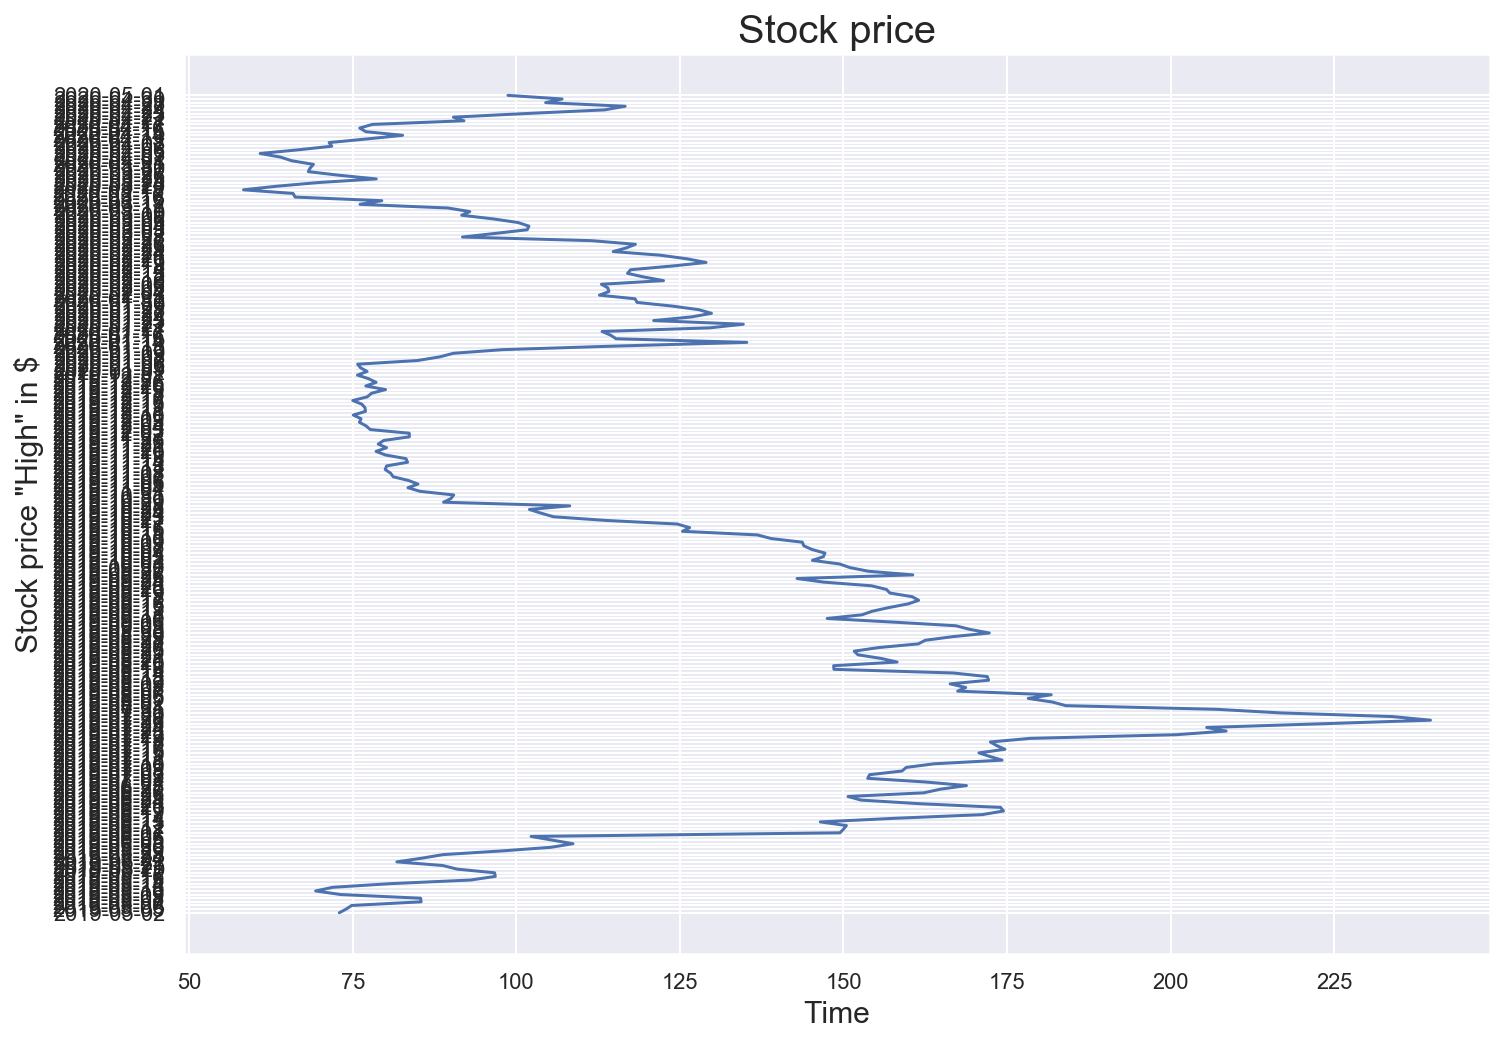

In [25]:
# Plotting stock data
y = df1['High']
x = df1['Date']
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.plot(x,y)
plt.xlabel("Time", size=15)
plt.ylabel('Stock price "High" in $', size=15)
plt.title('Beyond Meat (BYND) Stock Chart', size=20)
plt.show()

***Milestone 1 - March 24th*** *You can submit the previous steps as a first notebook.*

**Sample split.** Do the standard 80% / 20% training/test split using all days in the data. In addition, do a separate temporal split where the training set is the first 80% of days in the time series.

**For all machine learning models**, report performance measure in test and train samples.

**Step 2a: estimate different regression models using `X_num` and `y`** [week 3]

***Milestone 2 - March 31th***  *You can submit the previous steps as a second notebook.*

**Step 3: text analysis** [week 4]
- Featurize tweets (or another text dataset related to your subject): transform the text into a standard document-level dataset `X_doc`

**Step 2b: estimate different regression models using `X_doc` and `y`** [week 3]

**Step 4: estimate a classification models** [week 5]
- propose a categorical variable `y_calc` that you can compute from the continuous one (`y`) (e.g. positive or negative growthin stock prices). For the `X` dimension, you can use `X_doc` or `X_num` or both. 
- you can use any other categorical variable that you find relevant 

***Milestone 3 - April 21th***  *You can submit the previous steps as a third notebook.*

**Step 6: Dimension reduction** [week 6]
- Use one of the dimension reductions methods to dimension-reduce the features
    - PCA or topic model (LDA or STM) or k-means clustering on the featurized text `X_doc`
- Run another classifier

**Step bonus: Econometric identification** [week 8]
- Find an exogenous shock affecting this firm (but not all the firms) and a control group of firms not affected
    - example: a natural disaster/shock to the exchange rate/change in ownership... affects the functionning of this firm but not the other firms of the stock market index.  
- scale up the previous data collection to the firms in the control group
- use one of the technique studied in class to causaly identify the impact of the exogenous shock on the stock market of the affected firm

***Milestone 4 - May 17th*** *You can submit the previous steps as a last notebook.*

---------------------------
**Requirement for completion grade**: 
- the homework should be done in **groups of 1 or 2 persons** 
- the homework will have to be submitted as a (Python or R) **notebooks**
- you can give them back at the indicated **milestone** or on May 17th (no homework will be accepted after May 17th)
- the notebooks should contain at least **three graphs** (overall)
- each notebook should run from the beginning to then end, but:
    - beware of paths to folders that are on your computer but not on mine
    - if you have such a path, you can: 
        - have the data downloaded in the notebook directly
        - import your data in a github (or any other online storage) folder that the notebook can access  
    - indicate if the notebook takes more than 30 minutes to run
- do not write us emails regarding the homework, ask your questions on the **forum**, it will benefit everyone for sure! 

---------------------------